In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


2023-09-17 12:34:09.977335: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


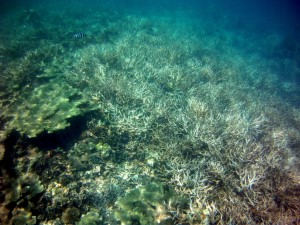

In [4]:
import pathlib

data_dir = pathlib.Path('./')
healthy_coral = list(data_dir.glob('Healthy Coral/*'))
bleached_coral = list(data_dir.glob('Bleached Coral/*'))
PIL.Image.open(str(healthy_coral[0]))
PIL.Image.open(str(bleached_coral[0]))


In [5]:
batch_size = 32
img_height = 300
img_width = 300

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 923 files belonging to 3 classes.
Using 739 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 923 files belonging to 3 classes.
Using 184 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)


['.ipynb_checkpoints', 'Bleached Coral', 'Healthy Coral']


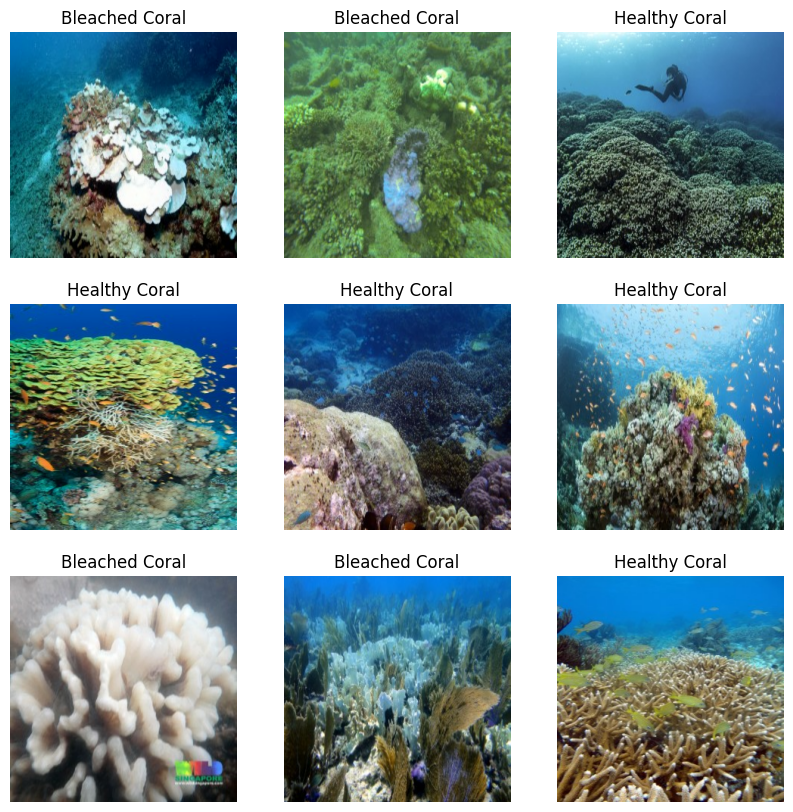

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 300, 300, 3)
(32,)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [12]:
normalization_layer = layers.Rescaling(1./255)


In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


In [14]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [16]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 150, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        1

In [17]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
24/24 [==============================] - 18s 717ms/step - loss: 1.0101 - accuracy: 0.6319 - val_loss: 0.6428 - val_accuracy: 0.7011
Epoch 2/10
24/24 [==============================] - 16s 680ms/step - loss: 0.5512 - accuracy: 0.7321 - val_loss: 0.5631 - val_accuracy: 0.6793
Epoch 3/10
24/24 [==============================] - 16s 671ms/step - loss: 0.4745 - accuracy: 0.7564 - val_loss: 0.5392 - val_accuracy: 0.6902
Epoch 4/10
24/24 [==============================] - 18s 746ms/step - loss: 0.4397 - accuracy: 0.8051 - val_loss: 0.5206 - val_accuracy: 0.7337
Epoch 5/10
24/24 [==============================] - 18s 768ms/step - loss: 0.4161 - accuracy: 0.8078 - val_loss: 0.5583 - val_accuracy: 0.7283
Epoch 6/10
24/24 [==============================] - 17s 724ms/step - loss: 0.3441 - accuracy: 0.8498 - val_loss: 0.5918 - val_accuracy: 0.7228
Epoch 7/10
24/24 [==============================] - 18s 760ms/step - loss: 0.2755 - accuracy: 0.8823 - val_loss: 0.5923 - val_accuracy: 0.7120

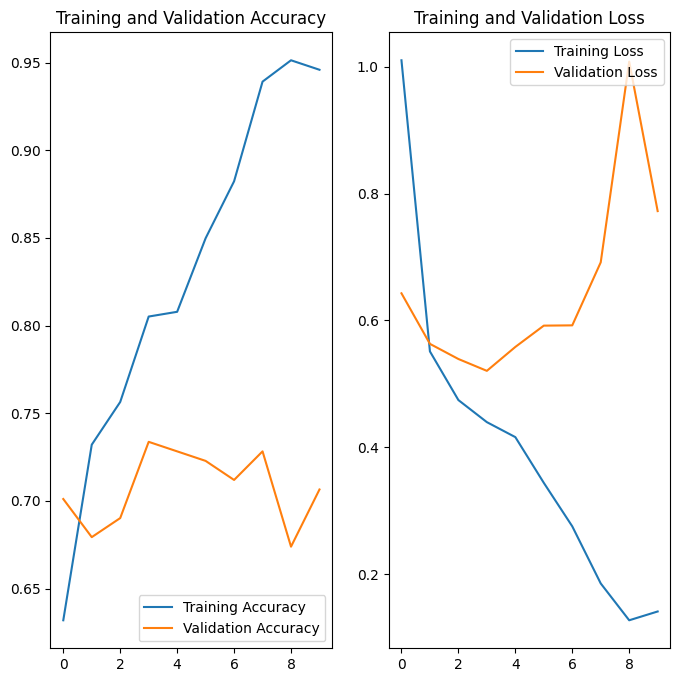

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
